# Project: Nonlinear Elliptic Problem POD vs PINNs

Let us consider the two-dimensional spatial domain $\Omega = [0, 1]^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0,\mu_1) \in P = [0.1,1]^2$, find $u(\mu)$ such that

$-\Delta u(\mu)+\frac{\mu_0}{\mu_1}(e^{\mu_1 u(\mu)}-1) = g(x;\mu)$,

with homogeneous Dirichlet boundary conditions and the source term defined as 

$g(x;\mu) = 100\sin(2\pi x_0)\cos(2\pi x_1) \ \ \ \forall x = (x_0,x_1) \in \Omega$.

In particular, we will solve the problem by means of POD-Galerkin method over a finite element full order model and then with a parametric PINN. We want to compare the two approaches in terms of computational costs and accuracy with respect to the full order model.

### Import libraries

In [21]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt
import time

### Initialize

In [2]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [3]:

def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu[0]*np.exp(mu[1]*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu[0]/mu[1]*(np.exp(mu[1]*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data

def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
    return values_g.ctypes.data

def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu[0]/mu[1]*(np.exp(mu[1]*vecu)-1)
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

### Definition of Simulation Parameters

#### Geometry parameters

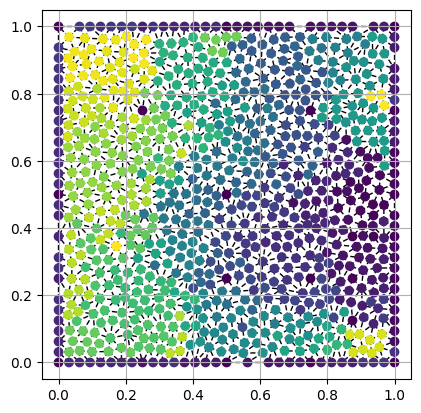

(3, 713)


In [4]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotDofs(mesh,dofs,strongs)
print(dofs.shape)

### High Fidelity

#### Newton Algorithm

In [5]:
mu = [0.5, 0.1]

def compute_exact_FOM(mu, lib, problemData):
    # Newton parameters
    residual_norm = 1.0
    solution_norm = 1.0
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1
    
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_f, problemData, lib)
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_errorL2 = gedim.ComputeErrorL2(Progetto_exactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Progetto_exactDerivativeSolution, u_k, u_strong, lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        
        solution_norm = u_normL2;
        residual_norm = du_normL2;
        
        #print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        
        num_iteration = num_iteration + 1

    return u_k, u_strong, u_errorL2/u_normL2, u_errorH1/u_normH1

In [6]:
[u_ex, u_strong, error_L2, error_H1] = compute_exact_FOM(mu, lib, problemData)

print("HIGH FIDELITY SOLUTION")
print("dofs", "h", "errorL2", "errorH1")
print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(error_L2), '{:.16e}'.format(error_H1))     

HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1
713 6.4341029499729044e-02 2.6529949243323976e-03 5.1347302021095206e-02


### Plot High Fidelity exact solution

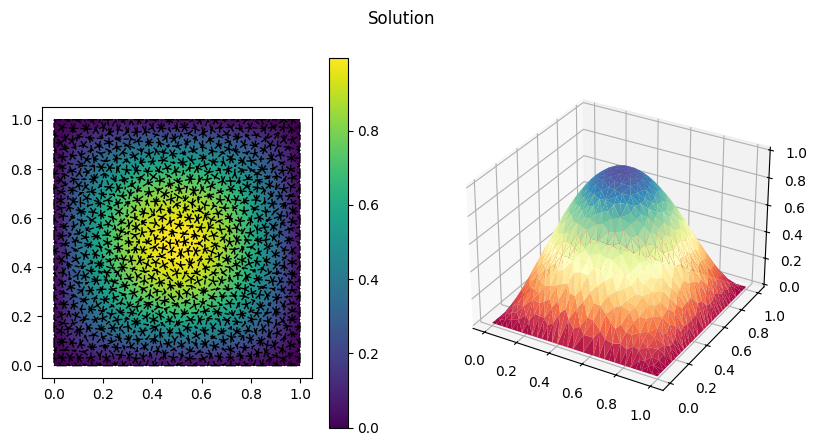

In [7]:
gedim.PlotSolution(mesh, dofs, strongs, u_ex, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_ex, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_ex, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

### Test on the convergence order

In [8]:
meshSizes = [0.1, 0.01, 0.001]

error_L2 = []
error_H1 = []

for meshSize_test in meshSizes:
    domain_test = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize_test }
    [meshInfo_test, mesh_test] = gedim.CreateDomainSquare(domain_test, lib)
    discreteSpace_test = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
    [problemData_test, dofs_test, strongs_test] = gedim.Discretize(discreteSpace_test, lib)
    
    [u_exact, u_strong, err_L2, err_H1] = compute_exact_FOM(mu, lib, problemData_test)
    
    error_L2.append(err_L2)
    error_H1.append(err_H1)

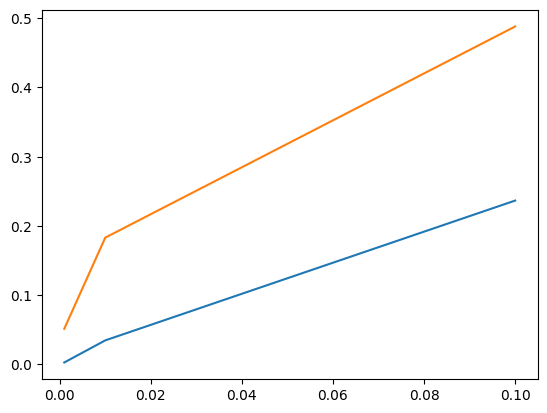

In [9]:
import matplotlib.pyplot as plt

plt.clf()
x = meshSizes
y = error_L2
plt.plot(x, y) 

y = error_H1
plt.plot(x, y) 

In [10]:
pol_L2 = np.polyfit(np.log(x), np.log(error_L2), 1)
pol_H1 = np.polyfit(np.log(x), np.log(error_H1), 1)
order_L2 = pol_L2[0]
order_H1 = pol_H1[0]
print("order_L2", "order_H1")
print(order_L2, order_H1)

order_L2 order_H1
0.9751241237932254 0.4890074628443306


In [22]:
# high fidelity solution with g

def compute_FOM(mu, lib, problemData):
    # Newton parameter
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1
    
    u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    
    start_assembling_FOM = time.time()
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    time_assembling_FOM = time.time() - start_assembling_FOM
    
    while num_iteration < max_iterations: 
        start_assembling2_FOM = time.time()
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        time_assembling2_FOM.append(time.time() - start_assembling2_FOM)
        
        # full solution computation timer
        start_compute_FOM = time.time()
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
        
        time_compute_FOM.append(time.time() - start_compute_FOM)
        
        #print("dofs", "h", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
        
        num_iteration = num_iteration + 1
        
    total_assemble =  time_assembling_FOM + sum(time_assembling2_FOM)
    total_compute_sol = sum(time_compute_FOM)
    time_FOM = total_assemble + total_compute_sol
    
    return u_k, u_strong, time_FOM

### Plot High Fidelity solution

In [23]:
[u_k, u_strong] = compute_FOM(mu, lib, problemData)

gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

NameError: name 'time_assembling2_FOM' is not defined

# POD

## Offline phase 

We here define the finite parametric space $\mathcal P_{train}$, with random uniform distributed realization of $\boldsymbol \mu$.
The cardinality of $\mathcal P_{train}$ is set to $M = 300$.

In [13]:
### define the training set

snapshot_num = 300 
mu0_range = [0.1, 1.]
mu1_range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0_range, mu1_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

We now define the _snapshot matrix_. The snapshot matrix is $\mathbb U \in \mathbb R^{{M} \times {\mathcal N}}$, the matrix that contains by columns the high fidelity solutions of the problem related to a set of $M$ selected parameters.

In [14]:
#### snapshot matrix creation
snapshot_matrix = []

tol = 1. -1e-7
N_max = 10

for mu in training_set:
    [u_k_snap, u_strong_snap] = compute_FOM(mu, lib, problemData)
    
    snapshot = u_k_snap
    snapshot_matrix.append(np.copy(snapshot))
    
snapshot_matrix = np.array(snapshot_matrix) 


To build the $N$-dimesional framework we need, we define the covariance matrix $\mathbf C \in \mathbb R^{M \times M}$ and we solve the eigenvalue problem
$
    \mathbf C \omega_n = \lambda_n \omega_n
$ for $ 1 \leq n \leq M,$ with $\lvert \lvert {\omega_n}\rvert \rvert_{\mathbb V} = 1$. 
We can order the all-positive eigenvalues as $\lambda_1 >\dots > \lambda_{M}> 0$ and retain the first $N$ eigenpairs $(\lambda_n, \omega_n)$ for $1 \leq n \leq N$. 

$N$ is chosen looking at the eigenvalues. Indeed, defining as  $P_N: \mathbb V \rightarrow \mathbb V_N$ the projector from $\mathbb V$ onto $ {\mathbb V}_N$, $N$ is chosen such that the quantity:
\begin{equation}
    \sqrt{\frac{1}{M}
    \sum_{i = 1}^{M}  \lvert \lvert {u^{\mathcal N}(\boldsymbol{\mu}_{i}) - P_N(u^{\mathcal N}(\boldsymbol{\mu}_i))\rvert \rvert }_{2}^2} = \sqrt{
    \sum_{i = N + 1}^{M}\lambda_m.}
\end{equation}
remains below a fixed tolerance.

In [15]:
### covariance matrix
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
inner_product = stiffness

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 


L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)
#print(relative_retained_energy)

The reduced dimension is 3


In [16]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) 
  
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (713, 3)


# Online phase

In [17]:
def compute_POD_solution(mu, lib, problemData):
    # Newton parameter
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1
    u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
    u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
    u_k_red = np.zeros(N, order='F')
    [stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
    
    forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
    
    while num_iteration < max_iterations: 
        [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)
    
        reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions
        reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
        reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red
    
        du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
                reduced_g - reduced_v - reduced_der_v, \
                lib)
        u_k_red = u_k_red + du_red
    
        u_k_proj = basis_functions @ u_k_red
        du_proj = basis_functions @ du_red

        num_iteration = num_iteration + 1

    return u_k_proj, u_strong_red


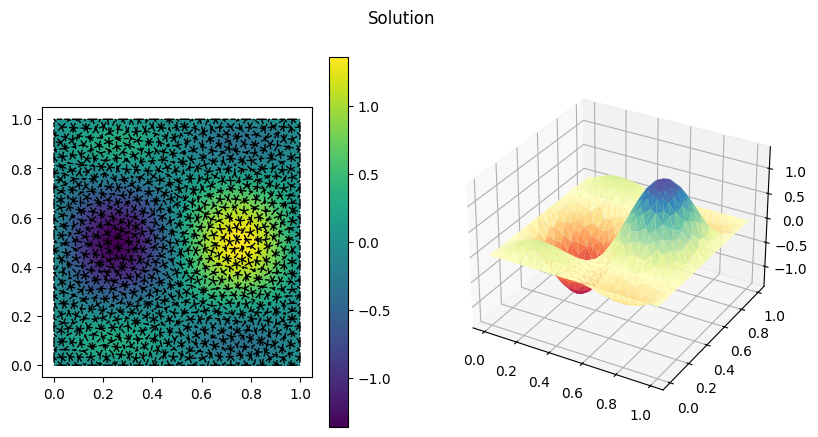

In [18]:
[u_k_proj, u_strong] = compute_POD_solution(mu, lib, problemData)

gedim.PlotSolution(mesh, dofs, strongs, u_k_proj, u_strong)

#gedim.ExportSolution(Progetto_exactSolution, u_k_proj, u_strong_red, lib)
#[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k_proj, u_strong_red, lib)
#gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [19]:
### compute error

abs_err = []
abs_err_L2 = []
rel_err = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong] = compute_FOM(mu, lib, problemData)
    
    [u_k_proj, u_strong_red] = compute_POD_solution(mu, lib, problemData)
    
    error_vector = u_k - u_k_proj
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [20]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')


Average relative error: 0.00025094013667066324
Average absolute error: 0.0011483938571881457
Average relative L2 error: 0.00017688552442227058
Average absolute L2 error: 0.002546224724816831


## PINN

In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable

seed = 35
np.random.seed(seed)
torch.manual_seed(seed)

Let us define the Neural Network.

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        #self.hidden_layer5 = nn.Linear(7,7)
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1):
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1)
        layer1_out = torch.sigmoid(self.input_layer(input)) #
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        #layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        output = self.output_layer(layer5_out)
        return output

Model

In [23]:
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [24]:
## PDE as loss function
def R(x_0,x_1,mu_0,mu_1,net):
    u = net(x_0,x_1,mu_0,mu_1) # the dependent variable u is given by the network based on independent variables x_0,x_1,mu_0,mu_1
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0]
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0]

    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0]
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0]

    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))

    pde = -u_xx + mu_0/mu_1*(torch.exp(mu_1*u)-1) - g
    return pde

In [25]:
dim = 600
x0 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))
x1 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))

all_zeros = np.zeros((dim,1))
all_ones = np.ones((dim,1))

lh = np.concatenate([x0, all_ones, x0, all_zeros],axis=0)
rl = np.concatenate([all_zeros, x1, all_ones, x1],axis=0)

u_bc = np.zeros((dim*4,1))

# training set relative to mu
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))

# training set relative to interior points
x0_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1)) 
x1_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1))

gamma = 1000
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x0_bc = Variable(torch.from_numpy(lh).float(), requires_grad=False)
    pt_x1_bc = Variable(torch.from_numpy(rl).float(), requires_grad=False)

    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    tensor_mu_0 = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
    tensor_mu_1 = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
    net_bc_out = net(pt_x0_bc, pt_x1_bc, tensor_mu_0, tensor_mu_1) # output of u(x0,x1,mu_0,mu_1)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE        
    all_zeros = np.zeros((dim*4,1))
    
    pt_x0_collocation = Variable(torch.from_numpy(x0_collocation).float(), requires_grad=True)
    pt_x1_collocation = Variable(torch.from_numpy(x1_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = R(pt_x0_collocation, pt_x1_collocation, tensor_mu_0, tensor_mu_1, net) # output of R(x_0,x_1,mu_0,mu_1,net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = gamma*mse_u + mse_f
    
    loss.backward() 
    optimizer.step()
    
    with torch.autograd.no_grad():
        if epoch % 500 == 0:
            print(epoch,"Loss:",loss.item())


0 Loss: 2587.41796875
500 Loss: 2330.974609375
1000 Loss: 1049.8658447265625
1500 Loss: 897.6005249023438
2000 Loss: 54.04963302612305
2500 Loss: 27.00386619567871
3000 Loss: 21.031455993652344
3500 Loss: 18.675994873046875
4000 Loss: 16.76280403137207
4500 Loss: 14.676788330078125
5000 Loss: 13.601119995117188
5500 Loss: 13.601617813110352
6000 Loss: 11.994563102722168
6500 Loss: 11.35175895690918
7000 Loss: 10.782150268554688
7500 Loss: 17.100357055664062
8000 Loss: 9.673781394958496
8500 Loss: 9.150067329406738
9000 Loss: 8.670854568481445
9500 Loss: 8.34212589263916


## Test

In [26]:
meshSize = 0.001
order = 1
#all the boundary conditions are homogenous dirichlet boundary conditions so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
#[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

# BoundaryConditionsType=2 means Dirichlet conditions
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# boundary points
x0_bc = strongs[0].reshape(-1,1)
x1_bc = strongs[1].reshape(-1,1)

# transform to tensor
x_0_bc_tensor = Variable(torch.from_numpy(x0_bc).float(), requires_grad=False)
x_1_bc_tensor = Variable(torch.from_numpy(x1_bc).float(), requires_grad=False)

# interior points
x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)

# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu = [0.5, 0.1]
mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)

mu_0_bc_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
mu_1_bc_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)

## Prediction

In [27]:
def predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net):

    all_zeros = np.zeros((x_1_tensor.shape[0],1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
    u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)
    
    u_x0 = torch.autograd.grad(u_pred.sum(), x_0_tensor, create_graph=True)[0] #derivative of u over x_0
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0_tensor, create_graph=True)[0]
    
    
    u_x1 = torch.autograd.grad(u_pred.sum(), x_1_tensor, create_graph=True)[0] #derivative of u over x_1
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1_tensor, create_graph=True)[0] #second derivative of u over x_1
    
    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0_tensor.detach().numpy()) * np.cos(2 * np.pi * x_1_tensor.detach().numpy()))
    
    f_nolin = mu_0_tensor / mu_1_tensor * (torch.exp(mu_1_tensor * u_pred)-1)
    
    pde = - u_xx + f_nolin - g
    
    mse_f = mse_cost_function(pde, pt_all_zeros)

    return u_pred

In [28]:
u_pred = predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net) 
u_pred = u_pred.data.cpu().numpy().astype(np.float64)
u_pred = u_pred.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

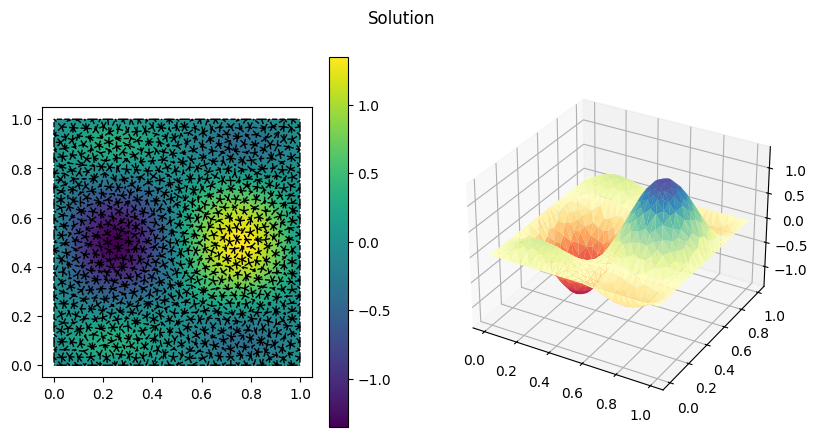

In [29]:
gedim.PlotSolution(mesh, dofs, strongs, u_pred, u_strong)

## Error

In [30]:
### compute error

abs_err = []
rel_err = []
abs_err_L2 = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong] = compute_FOM(mu, lib, problemData)
    mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    
    u_predicted = predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net) 
    u_predicted = u_predicted.data.cpu().numpy().astype(np.float64)
    u_predicted = u_predicted.reshape(-1)
    
    error_vector = u_k - u_predicted
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [31]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')

Average relative error: 0.08737251486319304
Average absolute error: 0.4004985647573694
Average relative L2 error: 0.029824393436966246
Average absolute L2 error: 0.43022903421787256


# POD-NN

In [32]:
import torch.nn.functional as F

mu_dim = P.shape[0]
basis_dim = N 
input_dim = mu_dim # equal to the dim of parameter space
output_dim = basis_dim # basis number chosen before
nodes = 30 # number of nodes inside

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, output_dim) # 4 layers before the output
        self.tanh = nn.Tanh() #activation function
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
        return x

In [33]:
seed_num = 31
torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1.

In [34]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
y_train = []

#given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)

for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)

In [35]:
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
  #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step() 
  if epoch % 200 == 199:
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

epoch 199 loss 250.40704345703125 lr 0.001
epoch 399 loss 155.4779815673828 lr 0.001
epoch 599 loss 99.57166290283203 lr 0.001
epoch 799 loss 65.96699523925781 lr 0.001
epoch 999 loss 44.42564392089844 lr 0.001
epoch 1199 loss 30.123563766479492 lr 0.001
epoch 1399 loss 20.533416748046875 lr 0.001
epoch 1599 loss 14.170156478881836 lr 0.001
epoch 1799 loss 9.920784950256348 lr 0.001
epoch 1999 loss 7.053513526916504 lr 0.001
epoch 2199 loss 5.085117816925049 lr 0.001
epoch 2399 loss 3.709120988845825 lr 0.001
epoch 2599 loss 2.737555980682373 lr 0.001
epoch 2799 loss 2.0507090091705322 lr 0.001
epoch 2999 loss 1.5608993768692017 lr 0.001
epoch 3199 loss 1.2010711431503296 lr 0.001
epoch 3399 loss 0.9329426884651184 lr 0.001
epoch 3599 loss 0.7355128526687622 lr 0.001
epoch 3799 loss 0.5985297560691833 lr 0.001
epoch 3999 loss 0.474500834941864 lr 0.001
epoch 4199 loss 0.38430488109588623 lr 0.001
epoch 4399 loss 0.3108576834201813 lr 0.001
epoch 4599 loss 0.28116804361343384 lr 0.001
e

In [36]:
#we compute the solution

x_test = [[.8, .4]] 
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0] #we transform the tensor in an array form

print(reduced_solution)

[-38.404305    0.6057673 -33.23305  ]


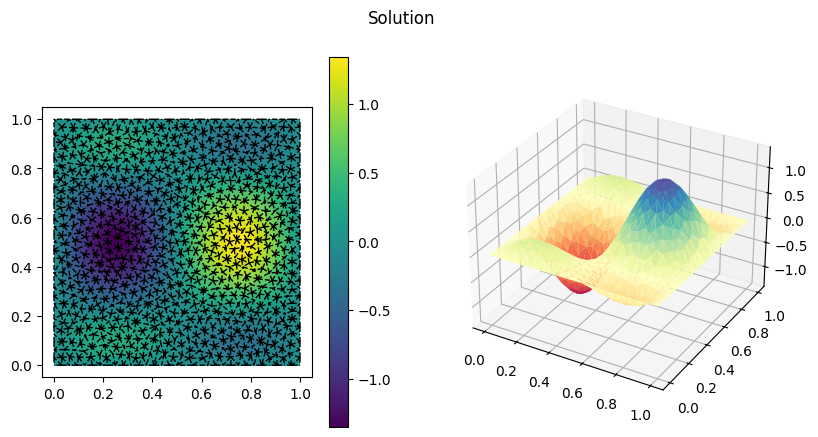

In [37]:
nn_proj_reduced_solution = basis_functions @ reduced_solution # we want to see the solution in the high fidelity setting
mu = x_test[0]

u_strong = np.zeros(problemData['NumberStrongs'], order='F') 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, u_strong)

### Error

In [38]:
abs_err = []
rel_err = []
abs_err_L2 = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong] = compute_FOM(mu, lib, problemData)

    x_test = [[mu[0], mu[1]]] 
    x_test = np.float32(x_test)
    x_test = torch.tensor(x_test)
    
    reduced_sol = np.asarray(net(x_test).detach().numpy())[0]
    nn_proj_reduced_sol = basis_functions @ reduced_sol
    
    error_vector = u_k - nn_proj_reduced_sol
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [39]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')

Average relative error: 0.0008725592444679311
Average absolute error: 0.003991881764827265
Average relative L2 error: 0.0008148833465590787
Average absolute L2 error: 0.011725807039581078
